# M-estimation for Life Science Research
Using life science research examples, we demonstrate the following advantages of M-estimation: robust statistics, automatic estimation of the variance for transformations of parameters, and lets uncertainty in nuisance parameters to propagate to the interest parameter.

In [1]:
# Loading packages for examples
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import delicatessen
from delicatessen import MEstimator
from delicatessen.data import load_robust_regress, load_inderjit
from delicatessen.estimating_equations import (ee_linear_regression, ee_robust_linear_regression,
                                               ee_3p_logistic, ee_effective_dose_delta,
                                               ee_logistic_regression)
from delicatessen.utilities import inverse_logit

decimal_places = 3
np.random.seed(51520837)

print("NumPy version:       ", np.__version__)
print("SciPy version:       ", sp.__version__)
print("Pandas version:      ", pd.__version__)
print("Matplotlib version:  ", matplotlib.__version__)
print("Delicatessen version:", delicatessen.__version__)

NumPy version:        1.19.5
SciPy version:        1.5.4
Pandas version:       1.1.5
Matplotlib version:   3.3.4
Delicatessen version: 0.1


## Case Study 1: Robust Linear Regression
For the first example, we will look at robust regression. Outliers are a common problem across topic areas. The presence of outliers can produce unstable results, but merely excluding outliers should only be done when clearly a result of experimental error. To produce more reliable results with outliers, robust regression is an alternative. Rather than exclude outliers, robust regression allows them to contribute but reduces their overall influence on the estimated parameters. 

In this first case study, we compare 3 regression models with a simulated data set. First, we fit a regression model to data without an outlier as a reference point. Then an outlier was introduced and we compare standard linear regression with robust regression. All regression models were estimated using `delicatessen`'s pre-built estimating equations.

In [2]:
# Loading the data without the outlier to generate reference
d = load_robust_regress(outlier=False)       # Loads data without outlier
x = d[:, 0]                                  # Extract X-values (height)
y = d[:, 1]                                  # Extract Y-values (weight)
X = np.vstack((np.ones(x.shape[0]), x)).T    # Generate array of intercept and X values


def psi_case1_standard(theta):
    """Built-in estimating equation for linear regression.
    """
    return ee_linear_regression(theta=theta, 
                                X=X, 
                                y=y)


# Linear regression without the outlier for reference
lme = MEstimator(psi_case1_standard, 
                 init=[0., 0.])
lme.estimate(solver='hybr')

In [3]:
# Loading the data with the outlier
d = load_robust_regress(outlier=True)       # Loads data with outlier
y = d[:, 1]                                 # Extract Y-values (weight) with the outlier

# Linear regression with the outlier
ulme = MEstimator(psi_case1_standard, 
                  init=[0., 0.])
ulme.estimate(solver='hybr')

In [4]:
def psi_case1_robust(theta):
    """Built-in estimating equation for robust linear regression
    """
    return ee_robust_linear_regression(theta=theta, 
                                       X=X, 
                                       y=y, 
                                       k=1.345)


# Notice: the theta from the previous regression is used as pre-washed covariates
#   since robust regression can sometimes fail when starting values are too far.
rlme = MEstimator(psi_case1_robust, 
                  init=ulme.theta)
rlme.estimate(solver='hybr')

C:\Users\zivic\.pyenv\pyenv-win\versions\3.6.5\lib\site-packages\matplotlib\patches.py:1338: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  verts = np.dot(coords, M) + (x + dx, y + dy)


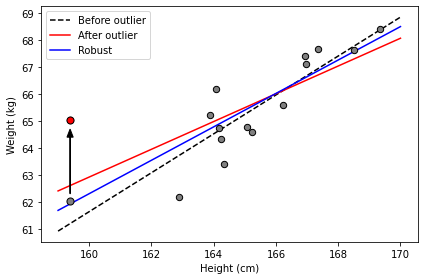

In [5]:
# Displaying results
plt.figure(figsize=[6, 4])

xlin = np.linspace(159, 170, 100)

# Plotting linear model results
plt.plot(xlin, lme.theta[0] + xlin*lme.theta[1],
         '--', color='k', label='Before outlier')
plt.plot(xlin, ulme.theta[0] + xlin*ulme.theta[1],
         '-', color='red', label='After outlier')
plt.plot(xlin, rlme.theta[0] + xlin*rlme.theta[1],
         '-', color='blue', label='Robust')

# Plotting the data points (including the outlier)
plt.scatter(x, y, s=40, c='gray', edgecolors='k', label=None, zorder=4)
plt.scatter([159.386], y[x == 159.386] - 3, s=50, c='gray', edgecolors='k', zorder=4)
plt.scatter([159.386], y[x == 159.386], s=50, c='red', edgecolors='k', zorder=5)
plt.arrow(159.386, y[x == 159.386] - 2.75, 0, 2.1, head_width=0.2, facecolor='k', zorder=5)

# Making nice labels for graph
plt.xlabel("Height (cm)")
plt.ylabel("Weight (kg)")
plt.legend()

# Outputting result
plt.tight_layout()

## Case Study 2: Dose-Response Curve
As a second case study, we consider estimation of dose-response relationships. Here, we replicate the results of Ritz et al. (2015) using data on herbicides and ryegrass root length (Inderjit et al. (2002)).

As there is a natural lower bound for root length, we used a 3-parameter log-logistic (3PL) model. Therefore, the 3PL model consists of the following parameters: halfway maximum effective concentration, steepness of the dose-response curve, and upper limit. In addition to the halfway (50%) effective concentration, we also estimate the 20% effective concentration. Both functionalities are provided in `delicatessen` with built-in estimating equations.

Here, another advantage of M-estimation is demonstrated. Specifically, the sandwich variance estimator allows us to estimate the variance for transformations of the parameters without any extra work (e.g., 20% effective concentration). 

In [6]:
d = load_inderjit()

In [7]:
def psi(theta):
    # Asserting that the lower limit is zero
    lower_limit = 0

    # Estimating equations for the 3PL model
    pl3 = ee_3p_logistic(theta=theta[0:3], 
                         X=d[:, 1], y=d[:, 0], 
                         lower=lower_limit)

    # Estimating equations for the effective concentrations
    ed20 = ee_effective_dose_delta(theta[3], y=d[:, 0], delta=0.20,
                                   steepness=theta[0], ed50=theta[1],
                                   lower=lower_limit, upper=theta[2])

    # Returning stacked estimating equations
    return np.vstack((pl3,
                      ed20))


# Optimization procedure
mest = MEstimator(psi, init=[2, 1, 10, 1])
mest.estimate(solver='lm', maxiter=2000)
ci_theta = mest.confidence_intervals()

In [8]:
# Printing the results to the console
print("==================================")
print("Case Study 2: Results")
print("==================================")
print("ED(50)")
print("----------------------------------")
print("Est:   ", np.round(mest.theta[0], decimal_places))
print("95% CI:", np.round(ci_theta[0],
                          decimal_places))
print("----------------------------------")
print("Steepness")
print("----------------------------------")
print("Est:   ", np.round(mest.theta[1], decimal_places))
print("95% CI:", np.round(ci_theta[1],
                          decimal_places))
print("----------------------------------")
print("Upper Limit")
print("----------------------------------")
print("Est:   ", np.round(mest.theta[2], decimal_places))
print("95% CI:", np.round(ci_theta[2],
                          decimal_places))
print("----------------------------------")
print("ED(20)")
print("----------------------------------")
print("Est:   ", np.round(mest.theta[3], decimal_places))
print("95% CI:", np.round(ci_theta[3],
                          decimal_places))
print("=========================================")

Case Study 2: Results
ED(50)
----------------------------------
Est:    3.263
95% CI: [2.743 3.784]
----------------------------------
Steepness
----------------------------------
Est:    2.47
95% CI: [1.897 3.043]
----------------------------------
Upper Limit
----------------------------------
Est:    7.855
95% CI: [7.554 8.157]
----------------------------------
ED(20)
----------------------------------
Est:    1.862
95% CI: [1.581 2.143]


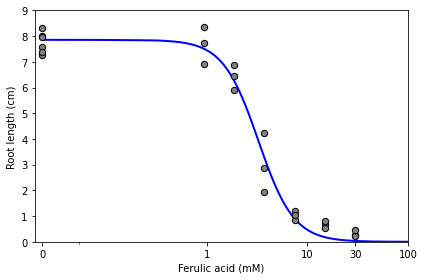

In [9]:
# Displaying results
plt.figure(figsize=[6, 4])

x = np.linspace(0, 100, 5000)
theta = mest.theta
y = 0 + (theta[2] - 0) / (1 + (x/theta[0])**theta[1])

# Plotting points and drawing dose-response line
plt.plot(x, y, '-', color='blue', linewidth=2)
plt.scatter(d[:, 1], d[:, 0], s=40, c='gray', edgecolors='k', zorder=5)

plt.ylim([0, 9])
plt.ylabel("Root length (cm)")
plt.xscale('symlog', linthresh=0.3)
plt.xlim([-0.02, 100])
plt.xticks([0, 1, 10, 30, 100],
           ["0", "1", "10", "30", "100"])
plt.xlabel("Ferulic acid (mM)")
plt.tight_layout()

## Case Study 3: Standardization to external population
For the third example, we consider the standardization of results to an external population. Specifically, we consider the case when the available data is not a random sample of the population of interest. As an archetypical example, consider the biomarker data among HIV patients (n=57) in Kamat et al. (2012). When comparing the prevalence of recent drug use (either cocaine or opiates) to the MACS/WIHS combined cohorts for 2018-2019,14 drug use is notably higher in Kamat et al.’s sample (70% versus 8%). As Kamat et al. further reported differential biomarker expression by cocaine use, these patterns may mean that the summary statistics for the biomarkers are not broadly generalizable.

To  account for the discrepancy in drug use, we standardized the mean for select biomarkers to the distribution of drug use in the MACS/WIHS cohorts using inverse odds weights. Inverse odds weights are estimated using a logistic regression model. Using the estimated inverse odds weights, the weighted means for each biomarker are then calculated.

While the parameters for the logistic model are not of primary interest (i.e., nuisance parameters), the estimates of weighted mean biomarkers depend on those regression parameters through the weights. This dependence means that the variance of the logistic model parameters should carry forward into the variance of the weighted means. Otherwise, there is a danger in underestimating the uncertainty. M-estimation addresses this problem by propagating the uncertainty of nuisance parameters through the stacked estimating equations and sandwich variance. This can be done by stacking the estimating equations for the logistic model and for the weighted biomarker means together. In this example, we provide both the unstandardized and standardized results.

In [10]:
# Loading Kamat et al. 2012
d1 = pd.read_csv("data/kamat.et.al.2012_biomarkers.csv")
d1['drug_use'] = np.where(d1['Cocaine'] + d1['Opiate'] > 0, 1, 0)
d1['S'] = 1
biomarkers = ['IFN_alpha', 'CXCL9', 'CXCL10', 'sIL-2R', 'IL12']
d1 = d1[['drug_use', 'S', ] + biomarkers].copy()
for bm in biomarkers:
    d1[bm] = np.log(d1[bm])


# MACS/ WIHS in 2018-2019 of cocaine or heroin use in previous 6 months
d0 = pd.DataFrame()
d0['drug_use'] = [1]*300 + [0]*(4016-300)
d0['S'] = 0


# Stacking data together and adding constant for model
d = pd.concat([d0, d1])           # Stacking data sets together
d['constant'] = 1                 # Creating constant for the intercept in the logit model
d[biomarkers] = d[biomarkers].fillna(9999)

In [11]:
def psi_standard_mean(theta):
    # Returning stacked estimating equations
    return (np.asarray(d1['IFN_alpha']) - theta[0],
            np.asarray(d1['CXCL9']) - theta[1],
            np.asarray(d1['CXCL10']) - theta[2],
            np.asarray(d1['sIL-2R']) - theta[3],
            np.asarray(d1['IL12']) - theta[4], )


nm = MEstimator(psi_standard_mean, init=[1]*5)  # ... and starting value for optimization procedure
nm.estimate()                                   # Run M-estimator and compute estimates

In [12]:
# Weighted means to standardize to population
x = np.asarray(d[['constant', 'drug_use']])
s = np.asarray(d['S'])


def psi_weighted_mean(theta):                           # Function for the estimating equations
    global x, y, s

    # Estimating weights
    nuisance = ee_logistic_regression(theta=theta[:2],
                                      X=x, y=s)
    pi = inverse_logit(np.dot(x, theta[:2]))
    weight = np.where(s == 1, (1-pi)/pi, 0)

    # Returning stacked estimating equations
    return np.vstack((nuisance,
                      s*weight*(np.asarray(d['IFN_alpha']) - theta[2]),
                      s*weight*(np.asarray(d['CXCL9']) - theta[3]),
                      s*weight*(np.asarray(d['CXCL10']) - theta[4]),
                      s*weight*(np.asarray(d['sIL-2R']) - theta[5]),
                      s*weight*(np.asarray(d['IL12']) - theta[6]), )
                     )


wm = MEstimator(psi_weighted_mean, init=[0, 0] + [1]*5)  # ... and starting value for optimization procedure
wm.estimate()                                            # Run M-estimator and compute estimates

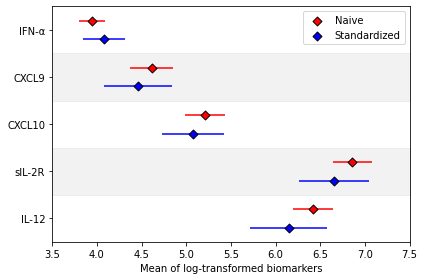

In [13]:
# Displaying results
plt.figure(figsize=[6, 4])

# Plotting point estimates
plt.scatter(nm.theta, [i-0.2 for i in range(len(biomarkers))],
            s=40, color='red', edgecolors='k', marker='D', zorder=3, label='Naive')
plt.scatter(wm.theta[2:], [i+0.2 for i in range(len(biomarkers))],
            s=40, color='blue', edgecolors='k', marker='D', zorder=3, label='Standardized')

# Plotting confidence intervals
plt.hlines([i-0.2 for i in range(len(biomarkers))],
           nm.theta - 1.96*np.diag(nm.variance)**0.5,
           nm.theta + 1.96 * np.diag(nm.variance)**0.5,
           colors='red')
plt.hlines([i+0.2 for i in range(len(biomarkers))],
           wm.theta[2:] - 1.96*np.diag(wm.variance)[2:]**0.5,
           wm.theta[2:] + 1.96 * np.diag(wm.variance)[2:]**0.5,
           colors='blue')

# Some shaded regions to make it easier to examine
plt.fill_between([3, 7.5], [3.5, 3.5], [2.5, 2.5], color='gray', alpha=0.1)
plt.fill_between([3, 7.5], [1.5, 1.5], [0.5, 0.5], color='gray', alpha=0.1)

plt.yticks([i for i in range(len(biomarkers))],
           ['IFN-α', 'CXCL9', 'CXCL10', 'sIL-2R', 'IL-12'])
plt.ylim([4.5, -0.5])
plt.xlim([3.5, 7.5])
plt.xlabel("Mean of log-transformed biomarkers")
plt.legend()
plt.tight_layout()

This concludes the 3 illustrative life science research examples.

## References
Ritz, C., Baty, F., Streibig, J. C. & Gerhard, D. Dose-Response Analysis Using R. PLOS ONE 10, e0146021 (2015).

Inderjit, Streibig, J. C. & Olofsdotter, M. Joint action of phenolic acid mixtures and its significance in allelopathy research. Physiol Plant 114, 422–428 (2002).

Kamat, A. et al. A Plasma Biomarker Signature of Immune Activation in HIV Patients on Antiretroviral Therapy. PLOS ONE 7, e30881 (2012).
